In [1]:
import os,csv,re,sys
import pandas as pd
import numpy as np
import scanpy as sc
import math
import SpaGCN as spg
import random, torch
from sklearn import metrics
import cv2
import matplotlib.pyplot as plt
from pathlib import Path
import sys
sys.path.append('/home/lytq/Spatial-Transcriptomics-Benchmark/utils')
from sdmbench import compute_ARI, compute_NMI, compute_CHAOS, compute_PAS, compute_ASW, compute_HOM, compute_COM

import time
import psutil
import tracemalloc

def evaluate_clustering(adata: sc.AnnData, df_meta, time_taken: float, memory_used: float, output_dir: str) -> dict:
    """Evaluate clustering using sdmbench"""
    gt_key = 'ground_truth'
    pred_key = 'refined_pred'
    adata.obs['ground_truth'] = df_meta['fine_annot_type'].values
    adata = adata[~pd.isnull(adata.obs['ground_truth'])]
    
    results = {
        "ARI": compute_ARI(adata, gt_key, pred_key),
        "AMI": compute_NMI(adata, gt_key, pred_key),
        "Homogeneity": compute_HOM(adata, gt_key, pred_key),
        "Completeness": compute_COM(adata, gt_key, pred_key),
        "ASW": compute_ASW(adata, pred_key),
        "CHAOS": compute_CHAOS(adata, pred_key),
        "PAS": compute_PAS(adata, pred_key),
        "Time": time_taken,
        "Memory": memory_used
    }
    
    df_results = pd.DataFrame([results])
    df_results.to_csv(os.path.join(output_dir, "metrics.csv"), index=False)
    return results

In [2]:
BASE_PATH = Path('/home/lytq/Spatial-Transcriptomics-Benchmark/data/BRCA1')
output_path = Path('/home/lytq/Spatial-Transcriptomics-Benchmark/results2/BRCA1/SpaGCN')

sample_name = 'V1_Human_Breast_Cancer_Block_A_Section_1'

print(f"================ Start Processing {sample_name} ======================")

dir_input = Path(f'{BASE_PATH}/{sample_name}/')
dir_output = Path(f'{output_path}/')
dir_output.mkdir(parents=True, exist_ok=True)

n_clusters = 20
    
time_start = time.time()
tracemalloc.start()

##### read data
adata = sc.read_visium(dir_input)
adata.var_names_make_unique()

spatial=pd.read_csv(f"{dir_input}/spatial/tissue_positions_list.csv",sep=",",header=None,na_filter=False,index_col=0)

adata.obs["x1"]=spatial[1]
adata.obs["x2"]=spatial[2]
adata.obs["x3"]=spatial[3]
adata.obs["x4"]=spatial[4]
adata.obs["x5"]=spatial[5]

adata=adata[adata.obs["x1"]==1]
adata.var_names=[i.upper() for i in list(adata.var_names)]
adata.var["genename"]=adata.var.index.astype("str")
# adata.write_h5ad(f"{dir_output}/sample_data.h5ad")

#Read in hitology image
# img=cv2.imread(f"{dir_input}/spatial/tissue_full_image.tif")

#Set coordinates
adata.obs["x_array"]=adata.obs["x2"]
adata.obs["y_array"]=adata.obs["x3"]
adata.obs["x_pixel"]=adata.obs["x4"]
adata.obs["y_pixel"]=adata.obs["x5"]
x_array=adata.obs["x_array"].tolist()
y_array=adata.obs["y_array"].tolist()
x_pixel=adata.obs["x_pixel"].tolist()
y_pixel=adata.obs["y_pixel"].tolist()

#Test coordinates on the image
# img_new=img.copy()
# for i in range(len(x_pixel)):
#     x=x_pixel[i]
#     y=y_pixel[i]
#     img_new[int(x-20):int(x+20), int(y-20):int(y+20),:]=0

# cv2.imwrite(f'{dir_output}/sample_map.jpg', img_new)

#Calculate adjacent matrix
b=49
a=1
adj=spg.calculate_adj_matrix(x=x_pixel,y=y_pixel, x_pixel=x_pixel, y_pixel=y_pixel, beta=b, alpha=a, histology=False)
# np.savetxt(f'{dir_output}/adj.csv', adj, delimiter=',')


##### Spatial domain detection using SpaGCN
spg.prefilter_genes(adata, min_cells=3) # avoiding all genes are zeros
spg.prefilter_specialgenes(adata)
#Normalize and take log for UMI
sc.pp.normalize_per_cell(adata)
sc.pp.log1p(adata)

### 4.2 Set hyper-parameters
p=0.5 
spg.test_l(adj,[1, 10, 100, 500, 1000])
l=spg.find_l(p=p,adj=adj,start=100, end=500,sep=1, tol=0.01)
n_clusters=n_clusters
r_seed=t_seed=n_seed=100
res=spg.search_res(adata, adj, l, n_clusters, start=0.7, step=0.1, tol=5e-3, lr=0.05, max_epochs=20, r_seed=r_seed, 
                    t_seed=t_seed, n_seed=n_seed)

### 4.3 Run SpaGCN
clf=spg.SpaGCN()
clf.set_l(l)
#Set seed
random.seed(r_seed)
torch.manual_seed(t_seed)
np.random.seed(n_seed)
#Run
clf.train(adata,adj,init_spa=True,init="louvain",res=res, tol=5e-3, lr=0.05, max_epochs=200)
y_pred, prob=clf.predict()
adata.obs["pred"]= y_pred
adata.obs["pred"]=adata.obs["pred"].astype('category')
#Do cluster refinement(optional)
adj_2d=spg.calculate_adj_matrix(x=x_array,y=y_array, histology=False)
refined_pred=spg.refine(sample_id=adata.obs.index.tolist(), pred=adata.obs["pred"].tolist(), dis=adj_2d, shape="hexagon")
adata.obs["refined_pred"]=refined_pred
adata.obs["refined_pred"]=adata.obs["refined_pred"].astype('category')

df_meta = pd.read_csv(dir_input / 'metadata.tsv', sep='\t')
# adata.obs['layer_guess'] = df_meta['fine_annot_type']

sc.pp.neighbors(adata, n_neighbors=10)
sc.tl.umap(adata)

time_taken = time.time() - time_start
size, peak = tracemalloc.get_traced_memory()
tracemalloc.stop()
memory_used = peak / (1024 ** 2) # MB

clustering_results = evaluate_clustering(adata, df_meta, time_taken, memory_used, dir_output)

================ Start Processing V1_Human_Breast_Cancer_Block_A_Section_1 ======================


/home/lytq/.conda/envs/spagcn/lib/python3.8/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/lytq/.conda/envs/spagcn/lib/python3.8/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Calculateing adj matrix using xy only...
l is  1 Percentage of total expression contributed by neighborhoods: 0.0
l is  10 Percentage of total expression contributed by neighborhoods: 0.0
l is  100 Percentage of total expression contributed by neighborhoods: 0.13741850852966309
l is  500 Percentage of total expression contributed by neighborhoods: 21.58413132870435
l is  1000 Percentage of total expression contributed by neighborhoods: 83.64162436864945
L= 100 P= 0.13742
L= 101 P= 0.14795
L= 102 P= 0.15896
L= 103 P= 0.17042
L= 104 P= 0.18236
L= 105 P= 0.19476
L= 106 P= 0.20762
L= 107 P= 0.22093
L= 108 P= 0.23471
L= 109 P= 0.24893
L= 110 P= 0.26361
L= 111 P= 0.27873
L= 112 P= 0.29428
L= 113 P= 0.31027
L= 114 P= 0.32668
L= 115 P= 0.34351
L= 116 P= 0.36076
L= 117 P= 0.37841
L= 118 P= 0.39646
L= 119 P= 0.41491
L= 120 P= 0.43374
L= 121 P= 0.45295
L= 122 P= 0.47254
L= 123 P= 0.49248
Start at res =  0.7 step =  0.1
Initializing cluster centers with louvain, resolution =  0.7


/home/lytq/.conda/envs/spagcn/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Epoch  0
Epoch  10
Res =  0.7 Num of clusters =  13
Initializing cluster centers with louvain, resolution =  0.7999999999999999
Epoch  0
Epoch  10
Res =  0.7999999999999999 Num of clusters =  14
Res changed to 0.7999999999999999
Initializing cluster centers with louvain, resolution =  0.8999999999999999
Epoch  0
Epoch  10
Res =  0.8999999999999999 Num of clusters =  15
Res changed to 0.8999999999999999
Initializing cluster centers with louvain, resolution =  0.9999999999999999
Epoch  0
Epoch  10
Res =  0.9999999999999999 Num of clusters =  16
Res changed to 0.9999999999999999
Initializing cluster centers with louvain, resolution =  1.0999999999999999
Epoch  0
Epoch  10
Res =  1.0999999999999999 Num of clusters =  17
Res changed to 1.0999999999999999
Initializing cluster centers with louvain, resolution =  1.2
Epoch  0
Epoch  10
Res =  1.2 Num of clusters =  18
Res changed to 1.2
Initializing cluster centers with louvain, resolution =  1.3
Epoch  0
Epoch  10
Res =  1.3 Num of clusters =

In [3]:
df_meta['fine_annot_type']

0       Tumor_edge_5
1              IDC_4
2          Healthy_1
3              IDC_3
4              IDC_4
            ...     
3793           IDC_7
3794           IDC_4
3795           IDC_4
3796    Tumor_edge_2
3797    Tumor_edge_1
Name: fine_annot_type, Length: 3798, dtype: object

In [4]:
adata.obs

,in_tissue,array_row,array_col,x1,x2,x3,x4,x5,x_array,y_array,x_pixel,y_pixel,n_counts,pred,refined_pred,ground_truth
AAACAAGTATCTCCCA-1,1,50,102,1,50,102,15937,17428,50,102,15937,17428,11636.0,2,2,Tumor_edge_5
AAACACCAATAACTGC-1,1,59,19,1,59,19,18054,6092,59,19,18054,6092,52053.0,3,3,IDC_4
AAACAGAGCGACTCCT-1,1,14,94,1,14,94,7383,16351,14,94,7383,16351,4136.0,0,0,Healthy_1
AAACAGGGTCTATATT-1,1,47,13,1,47,13,15202,5278,47,13,15202,5278,22137.0,2,2,IDC_3
AAACAGTGTTCCTGGG-1,1,73,43,1,73,43,21386,9363,73,43,21386,9363,49659.0,3,3,IDC_4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTGTTGTGTGTCAAGA-1,1,31,77,1,31,77,11417,14023,31,77,11417,14023,18362.0,9,9,IDC_7
TTGTTTCACATCCAGG-1,1,58,42,1,58,42,17822,9233,58,42,17822,9233,19939.0,17,3,IDC_4
TTGTTTCATTAGTCTA-1,1,60,30,1,60,30,18294,7593,60,30,18294,7593,32222.0,3,3,IDC_4
TTGTTTCCATACAACT-1,1,45,27,1,45,27,14730,7190,45,27,14730,7190,18023.0,13,13,Tumor_edge_2


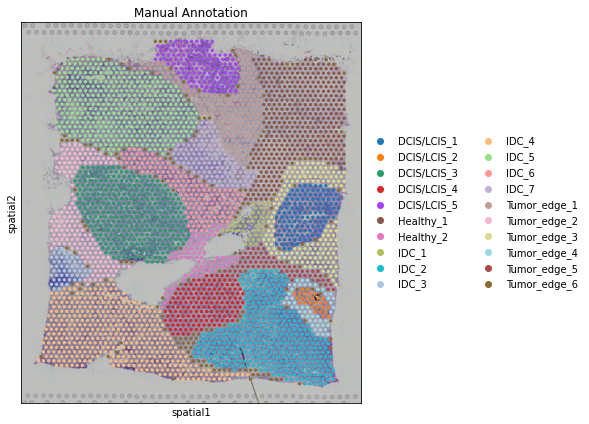

In [5]:
fig, axes = plt.subplots(1, 1, figsize=(8, 6))
sc.pl.spatial(adata, color='ground_truth', ax=axes, show=False)

axes.set_title('Manual Annotation')
plt.tight_layout()
plt.savefig(f'{dir_output}/ground_truth.pdf', dpi=300, bbox_inches='tight')


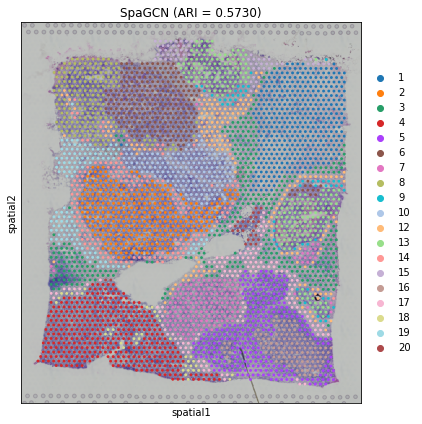

In [6]:
fig, axes = plt.subplots(1, 1, figsize=(6, 6))
sc.pl.spatial(adata, color='refined_pred', spot_size=150, ax=axes, show=False)
axes.set_title(f'SpaGCN (ARI = {clustering_results["ARI"]:.4f})')
handles, labels = axes.get_legend_handles_labels()
new_labels = [str(int(label) + 1) if label.isdigit() else label for label in labels]
axes.legend(handles, new_labels, loc='center left', frameon=False, bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.savefig(f'{dir_output}/clustering.pdf', dpi=300, bbox_inches='tight')

In [11]:
adata.obs

,in_tissue,array_row,array_col,x1,x2,x3,x4,x5,x_array,y_array,x_pixel,y_pixel,n_counts,pred,refined_pred,ground_truth,pred_shift
AAACAAGTATCTCCCA-1,1,50,102,1,50,102,15937,17428,50,102,15937,17428,11636.0,2,2,Tumor_edge_5,3
AAACACCAATAACTGC-1,1,59,19,1,59,19,18054,6092,59,19,18054,6092,52053.0,3,3,IDC_4,4
AAACAGAGCGACTCCT-1,1,14,94,1,14,94,7383,16351,14,94,7383,16351,4136.0,0,0,Healthy_1,1
AAACAGGGTCTATATT-1,1,47,13,1,47,13,15202,5278,47,13,15202,5278,22137.0,2,2,IDC_3,3
AAACAGTGTTCCTGGG-1,1,73,43,1,73,43,21386,9363,73,43,21386,9363,49659.0,3,3,IDC_4,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTGTTGTGTGTCAAGA-1,1,31,77,1,31,77,11417,14023,31,77,11417,14023,18362.0,9,9,IDC_7,10
TTGTTTCACATCCAGG-1,1,58,42,1,58,42,17822,9233,58,42,17822,9233,19939.0,17,3,IDC_4,4
TTGTTTCATTAGTCTA-1,1,60,30,1,60,30,18294,7593,60,30,18294,7593,32222.0,3,3,IDC_4,4
TTGTTTCCATACAACT-1,1,45,27,1,45,27,14730,7190,45,27,14730,7190,18023.0,13,13,Tumor_edge_2,14


In [7]:
adata

AnnData object with n_obs × n_vars = 3798 × 22218
    obs: 'in_tissue', 'array_row', 'array_col', 'x1', 'x2', 'x3', 'x4', 'x5', 'x_array', 'y_array', 'x_pixel', 'y_pixel', 'n_counts', 'pred', 'refined_pred', 'ground_truth'
    var: 'gene_ids', 'feature_types', 'genome', 'genename'
    uns: 'spatial', 'log1p', 'neighbors', 'umap', 'ground_truth_colors', 'refined_pred_colors'
    obsm: 'spatial', 'X_pca', 'X_umap'
    obsp: 'distances', 'connectivities'

In [8]:
adata.obs['pred_shift'] = (adata.obs['refined_pred'].astype(int) + 1).astype("category")

/home/lytq/.conda/envs/spagcn/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/lytq/.conda/envs/spagcn/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


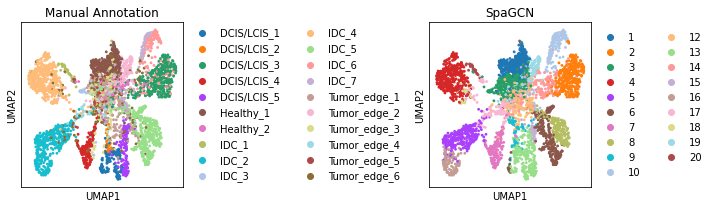

In [9]:
fig, axes = plt.subplots(1,2,figsize=(10, 3))
sc.pl.umap(adata, color='ground_truth', ax=axes[0], show=False)
sc.pl.umap(adata, color='pred_shift', ax=axes[1], show=False)
axes[0].set_title('Manual Annotation')
axes[1].set_title('SpaGCN')
# handles, labels = axes.get_legend_handles_labels()
# new_labels = [str(int(label) + 1) if label.isdigit() else label for label in labels]
# axes.legend(handles, new_labels, loc='center left', frameon=False, bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.savefig(f'{dir_output}/umap.pdf', dpi=300, bbox_inches='tight')

In [12]:
adata

AnnData object with n_obs × n_vars = 3798 × 22218
    obs: 'in_tissue', 'array_row', 'array_col', 'x1', 'x2', 'x3', 'x4', 'x5', 'x_array', 'y_array', 'x_pixel', 'y_pixel', 'n_counts', 'pred', 'refined_pred', 'ground_truth', 'pred_shift'
    var: 'gene_ids', 'feature_types', 'genome', 'genename'
    uns: 'spatial', 'log1p', 'neighbors', 'umap', 'ground_truth_colors', 'refined_pred_colors', 'pred_shift_colors'
    obsm: 'spatial', 'X_pca', 'X_umap'
    obsp: 'distances', 'connectivities'

In [10]:
low_dim_data = pd.DataFrame(adata.obsm['X_pca'], index=adata.obs.index)
cell_metadata = adata.obs
low_dim_data.to_csv(f"{dir_output}/low_dim_data.csv", index=False)
cell_metadata.to_csv(f"{dir_output}/cell_metadata.csv", index=False)

umap_coords = adata.obsm["X_umap"]
spot_ids = adata.obs_names
umap_df = pd.DataFrame(umap_coords, columns=["UMAP1", "UMAP2"])
umap_df["spot_id"] = spot_ids
umap_df = umap_df[["spot_id", "UMAP1", "UMAP2"]]
umap_df.to_csv(os.path.join(dir_output, "spatial_umap_coords.csv"), index=False)

# df_meta = df_meta[~pd.isnull(df_meta['layer_guess'])]

